# This program calculates shoulder location (with respect to elbow location) given the 3d-angular velocity of the shoulder, measurement 3d-location of elbow and shoulder, and length of shoulder-elbow.

In [11]:
# Importing libraries
import numpy as np
import pandas as pd
import random
import math
from sympy import *
import decimal
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

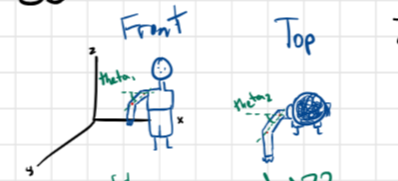

### Creating the Simulated Elbow Coordinates based off of Simulated Shoulder Coordinates

Important variable descriptions:
* thetaF (theta-front) is the array of angles (theta1 in the pic above) between the shoulder and arm along the XZ plane
* thetaT (theta-top) is the array of angles (theta2 in the pic above) between the shoulder and arm along the XY plane
* x = [zXs[0], zZs[0], thetaF[0], zYs[0], thetaT[0]].T
    * zXs represents simulated x-axis coordinates percieved by depth camera
    * zZs represents simulated z-axis (height) coordinates percieved by depth camera
    * zYs represents simulated y-axis (depth) coordinates percieved by depth camera
* Xs, Zs, Ys represent ground-truth data for shoulder
* Xe, Ze, Ye represent ground-truth data for elbow
* xrst, zrst, yrst represent coordinate approximations calculated by Kalman Filter

In [12]:
# Average arm length in meters
length = 0.33

pi = math.pi

In [13]:
# Simulating non-linear dynamics in the form of a parabola
# Forming thetaT=theta-front, Xs, Xe, Zs, and Ze arrays

# ThetaF array
thetaFNum = 90 #in radians
thetaF = [0] * 50 #90 degrees to 139 degrees
i=0
while i<50:
    thetaF[i] = thetaFNum * pi / 180 #in radians
    thetaFNum += 1
    i += 1

# Simulate angular velocity along x-axis and z-axis (x-axis angular velocity is sin wave)
wx = [1] * 50
i=0
while i<50:
    wx[i] = math.sin(i)
    i+=1

wz = [0] * 50


time = [0] * 50
i=0
while i < len(time):
    time[i] = i + 1
    i += 1

# Shoulder location in parabola
k=0
Xs = [0] * 50
Zs = [0] * 50
xVal = 0
while k<len(Xs):
    Xs[k] = xVal
    
# Four equations for the four testing environments
    zVal = -(1/14)*(xVal-24)*(xVal-24)+50 #Equation-1 parabola
#     zVal = (((xVal-4)*(xVal-35)**2)/500)+25 #Equation-2 cubic
#     zVal = abs(xVal-25) #Equation-3 absolute value function
#     zVal = math.sin(xVal/3)*10 #Equation-4 sine function

    Zs[k] = zVal
    xVal += 1
    k+=1

# Elbow location
h = 0
Xe = [0] * 50
Ze = [0] * 50
while h < len(Xe):
    Xe[h] = length * (math.cos(thetaF[h] + (wx[h]*time[h])))
    Xe[h] = Xs[h] - Xe[h]
    Ze[h] = length * (math.sin(thetaF[h] + (wz[h]*time[h])))
    Ze[h] = Zs[h] - Ze[h]
    h += 1

In [14]:
# Forming thetaT=theta-top, Ys, and Ye arrays

# ThetaT array
thetaTNum = 90 #in radians
thetaT = [0] * 50 #90 degrees to 139 degrees
i=0
while i<50:
    thetaT[i] = thetaTNum * pi / 180 #in radians
    thetaTNum += 1
    i += 1

# Simulate angular velocity along y-axis

wy = [0] * 50

time = [0] * 50
i=0
while i < len(time):
    time[i] = i + 1
    i += 1

# Shoulder location
k=0
Ys = [0] * 50
yVal = 0
while k<len(Ys):
    Ys[k] = yVal
    yVal += 1
    k+=1

# Elbow location
h = 0
Ye = [0] * 50
while h < len(Xe):
    Ye[h] = length * (math.sin(thetaT[h] + (wy[h]*time[h])))
    Ye[h] = Ys[h] - Ye[h]
    h += 1

In [15]:
# Measurement (camera-perceived) Coordinate Creation

zXs = []
zZs = []
zthetaF = []
zXe = []
zZe = []
zYs = []
zthetaT = []
zYe = []

# function that adds noise by a certain variable
def noise(list1, variability):
    finalList = []
    for element in list1:
        value = (float(decimal.Decimal(random.randrange(10, variability)))/100)*(random.choice([-1,1]))
        finalVal = element + value
        finalList.append(finalVal)
    return finalList

zXs = noise(Xs, 500)
zZs = noise(Zs, 500)
zthetaF = noise(thetaF, 50)
zXe = noise(Xe, 500)
zZe = noise(Ze, 500)
zYs = noise(Xe, 500)
zthetaT = noise(thetaT, 50)
zYe = noise(Ye, 500)

In [16]:
# Simulate occlusion data in the extended Kalman filter

def occlusion(list1, startCoord, variability):
    list2 = list1[:]
    i=0
    while i<25:
        modifier=(-1)**(random.randint(1, 2))
        list2[i+startCoord] = list1[i+startCoord] + (modifier*variability)
        i+=1
    return list2

zXs = occlusion(zXs, 25, 5)
zYs = occlusion(zYs, 25, 5)
zZs = occlusion(zZs, 25, 5)

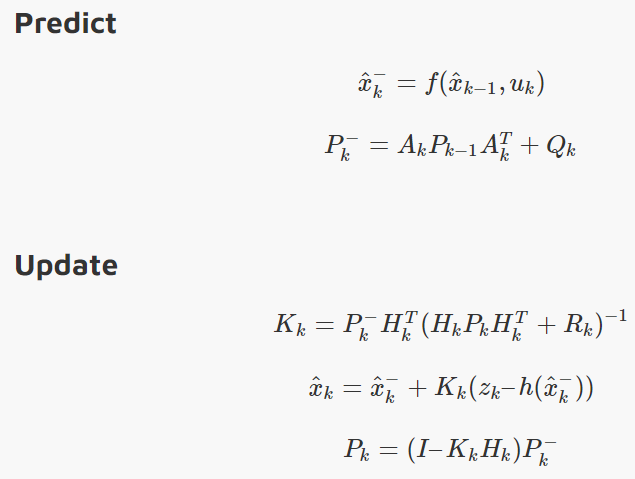

In [17]:
xInitial = np.matrix(([zXs[0], zZs[0], thetaF[0], zYs[0], thetaT[0]])).T

# KF predicted coordinates
xrst = [] # x-axis -> width
zrst = [] # z-axis -> height
yrst = [] # y-axis -> depth

# P is inital guess of covariance matrix, should be quite small like in the Kalman filter
P = 1*np.eye(5)

Q = 1*np.eye(5) # Another identity matrix for noise

p = 1*np.eye(5)

# R is measurement noise covariance matrix, tweak it through trial and error
R = np.matrix(([1, 0, 0],
               [0, 1, 0],
               [0, 0, 0.8]))


I = np.eye(5) #Identity matrix

# Arm length
length = 0.33

m = len(Xe)
for i in range(m):
    Jf = np.matrix([[1, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 1]])
    
    z = np.matrix(([zXe[i], zZe[i], zYe[i]])).T
    if i==0:
        x = xInitial

    x0 = float((str(x[0]).replace("[", "")).replace("]", ""))
    x1 = float((str(x[1]).replace("[", "")).replace("]", ""))
    x2 = float((str(x[2]).replace("[", "")).replace("]", ""))
    x3 = float((str(x[3]).replace("[", "")).replace("]", ""))
    x4 = float((str(x[4]).replace("[", "")).replace("]", ""))
    
    Jh = np.matrix(([[1, 0, length*(math.sin(x2)), 0, 0],
                     [0, 1, length*(math.cos(x2)), 0, 0],
                     [0, 0, 0, 1, length*(math.sin(x4))]]))

    P = Jf*P*(Jf.T) + Q    
    S = Jh*P*(Jh.T) + R
    K = P*(Jh.T) * np.linalg.pinv(S)

    px = np.matrix(([x0+(length*math.cos(x2))],
                    [x1+(length*math.sin(x2))],
                    [x3+(length*math.sin(x4))]))
    Y = z - px  # Measurement residual
    x = x + K*Y
    P = (I-(K*Jh))*P

    xrst.append(float(x[0]))
    zrst.append(float(x[1]))
    yrst.append(float(x[3]))    

In [18]:
# Calculate mean-squared error (MSE) stats

from sklearn.metrics import mean_squared_error

# Coordinates 0-25:
x_MSE_KF = mean_squared_error(Xs[0:25], xrst[0:25]) # comparison between real and KF
z_MSE_KF = mean_squared_error(Zs[0:25], zrst[0:25])
y_MSE_KF = mean_squared_error(Ys[0:25], yrst[0:25]) # depth axis

x_MSE_simu = mean_squared_error(Xs[0:25], zXs[0:25]) # comparison between real and noisy observation (camera-simulated) coordinates
z_MSE_simu = mean_squared_error(Zs[0:25], zZs[0:25])
y_MSE_simu = mean_squared_error(Ys[0:25], zYs[0:25])

print("Coordinates 0-25:")
print("KF prediction & ground truth shoulder MSE x_axis:", x_MSE_KF)
print("camera measurement & ground truth shoulder MSE x_axis:", x_MSE_simu)
print("KF prediction & ground truth shoulder MSE z_axis:", z_MSE_KF)
print("camera measurement & ground truth shoulder MSE z_axis:", z_MSE_simu)
print("KF prediction & ground truth shoulder MSE y_axis:", y_MSE_KF)
print("camera measurement & ground truth shoulder MSE y_axis:", y_MSE_simu)


# Coordinates 25-50:
x_MSE_KF = mean_squared_error(Xs[25:50], xrst[25:50]) # comparison between real and KF
z_MSE_KF = mean_squared_error(Zs[25:50], zrst[25:50])
y_MSE_KF = mean_squared_error(Ys[25:50], yrst[25:50]) # depth axis

x_MSE_simu = mean_squared_error(Xs[25:50], zXs[25:50]) # comparison between real and noisy observation (camera-simulated) coordinates
z_MSE_simu = mean_squared_error(Zs[25:50], zZs[25:50])
y_MSE_simu = mean_squared_error(Ys[25:50], zYs[25:50])

print("\nCoordinates 25-50:")
print("KF prediction & ground truth shoulder MSE x_axis:", x_MSE_KF)
print("camera measurement & ground truth shoulder MSE x_axis:", x_MSE_simu)
print("KF prediction & ground truth shoulder MSE z_axis:", z_MSE_KF)
print("camera measurement & ground truth shoulder MSE z_axis:", z_MSE_simu)
print("KF prediction & ground truth shoulder MSE y_axis:", y_MSE_KF)
print("camera measurement & ground truth shoulder MSE y_axis:", y_MSE_simu)

Coordinates 0-25:
KF prediction & ground truth shoulder MSE x_axis: 6.070217366772185
camera measurement & ground truth shoulder MSE x_axis: 7.985332
KF prediction & ground truth shoulder MSE z_axis: 8.903446811347699
camera measurement & ground truth shoulder MSE z_axis: 10.723976
KF prediction & ground truth shoulder MSE y_axis: 11.190930515132287
camera measurement & ground truth shoulder MSE y_axis: 7.4760933425671565

Coordinates 25-50:
KF prediction & ground truth shoulder MSE x_axis: 4.020952178633388
camera measurement & ground truth shoulder MSE x_axis: 44.776916
KF prediction & ground truth shoulder MSE z_axis: 3.720022879502323
camera measurement & ground truth shoulder MSE z_axis: 26.183151999999996
KF prediction & ground truth shoulder MSE y_axis: 5.27886937106756
camera measurement & ground truth shoulder MSE y_axis: 34.76213347469788


(-5.379849259081819, 51.73015074091818)

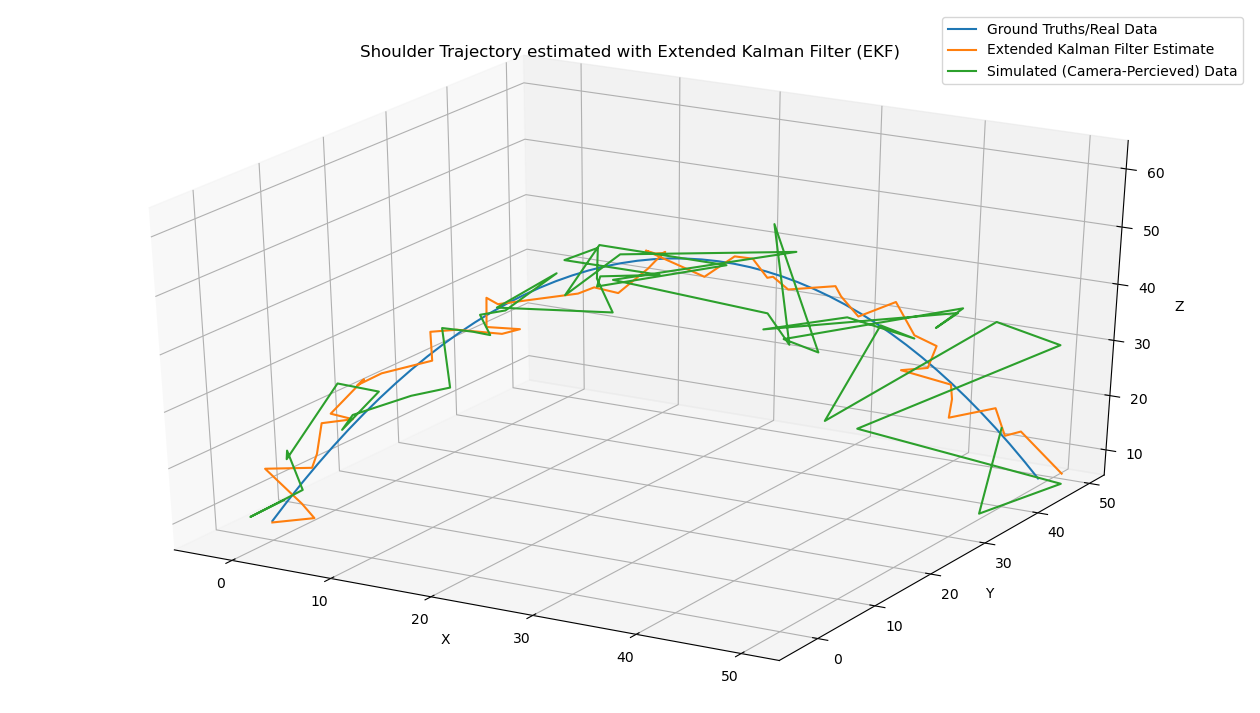

In [19]:
"""
Visualize the "camera-recognized" coordinates in comparison to the Extended Kalman Filter (EKF) coordinate approximations to 
understand whether the EKF appears to be more or less accurate.
"""
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs, Ys, Zs, label='Ground Truths/Real Data')
ax.plot(xrst, yrst, zrst, label='Extended Kalman Filter Estimate')
ax.plot(zXs, zYs, zZs, label='Simulated (Camera-Percieved) Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Shoulder Trajectory estimated with Extended Kalman Filter (EKF)')

max_range = np.array([max(zXs)-min(zXs), max(zYs)-min(zYs), max(zZs)-min(zZs)]).max() / 2.0

import statistics
mean_x = statistics.mean(zXs)
mean_z = statistics.mean(zZs)
mean_y = statistics.mean(zYs)

ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)

# Export EKF Data

In [480]:
df = pd.DataFrame({"xM" : zXs, "yM" : zYs, "zM" : zZs})
df.to_csv("Testing 1-15-24/Equation 4/eq4_M_trial_5.csv", index=False)

df = pd.DataFrame({"xEKF" : xrst, "yEKF" : yrst, "zEKF" : zrst})
df.to_csv("Testing 1-15-24/Equation 4/eq4_EKF_trial_5.csv", index=False)